# Summarize doc langgraph

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "genai-principles.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()
print(len(docs))

12


In [4]:
print(docs[0].page_content[0:200])
print(docs[0].metadata)

 
Karan Singh, Assistant Professor of Operations Research 
Principles of Generative AI 
A Technical Introduction 
Generative artificial intelligence (GenAI) tools are an emerging class of new-age arti
{'source': 'genai-principles.pdf', 'page': 0}


## Load Model

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

### Map Reduce

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate(
    [
        ("system", "Write a concise summary of the following:\\n\\n{context}")
    ]
)

map_chain = map_prompt | llm | StrOutputParser()

In [7]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

In [8]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents")

Generated 12 documents


In [9]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

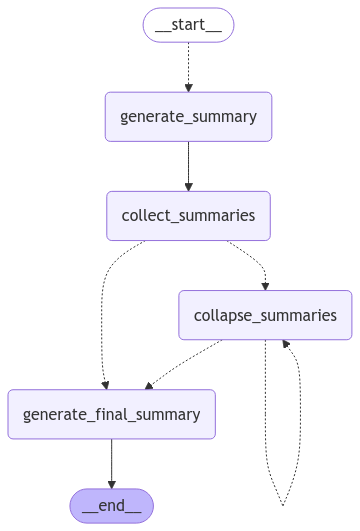

In [10]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [11]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [12]:
print(step)

{'generate_final_summary': {'final_summary': "Karan Singh, an Assistant Professor of Operations Research, provides a comprehensive analysis of generative artificial intelligence (GenAI) and large language models (LLMs), highlighting their transformative potential across various fields. Key themes include:\n\n1. **Functionality and Mechanisms of LLMs**: Singh explains LLMs as conditional probabilistic systems predicting the next word based on context, emphasizing their stochastic nature which introduces variability in responses.\n\n2. **Prompt Engineering**: The quality of input prompts is crucial for LLM performance, with effective prompt engineering significantly enhancing the coherence and utility of generated responses.\n\n3. **Evolution of Neural Networks**: The transition from Recurrent Neural Networks (RNNs) to Transformers is discussed, with Transformers noted for their ability to handle non-sequential context efficiently. Singh also addresses methodologies like contrastive lear

In [13]:
summary = step["generate_final_summary"]["final_summary"]

In [15]:
with open("summarize.md", "w") as f:
    f.write(summary)